# Imports and define expectation func

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [4]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_distributions, plot_distributions, plot_samples, plot_sampling_info, \
    plot_divergences, plot_history
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG
torch.set_default_dtype(torch.float64)

In [5]:
def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples(*args, **kwargs)
    plt.show()

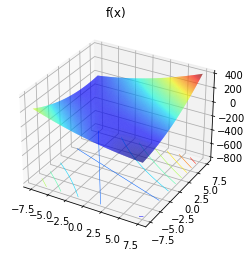

In [6]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Lumpy High Dimension Flow Target Distribution

In [7]:
torch.manual_seed(0) 
dim = 4
scaling_factor = 4.0
lr = 1e-4
weight_decay=1e-6
n_flow_steps=64
n_samples_estimation = int(1e6)
epochs = int(2e4)
batch_size = int(1e3)
train_prior=False

In [8]:
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3).to("cuda")
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # print twice to make sure estimates are resonably close

tensor(48.8308, device='cuda:0')
tensor(48.8308, device='cuda:0')


# DReG, alpha=2

In [9]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=scaling_factor, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=lr, 
                                  weight_decay=weight_decay)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

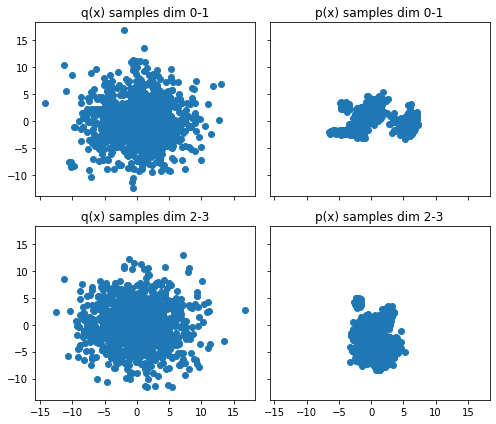

In [10]:
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

### If we want to train the prior first

In [11]:
if train_prior:
    history_prior = tester.train_prior(epochs=200, batch_size=batch_size, lr=0.01)
    plot_history(history_prior)
    plot_samples(tester)
    expectation_prior_trained, info_prior = tester.estimate_expectation(n_samples_estimation, expectation_function)

### proper training

loss: -0.10555133086318658, mean log p_x -47.613664192997646:   0%|          | 0/20000 [00:00<?, ?it/s]

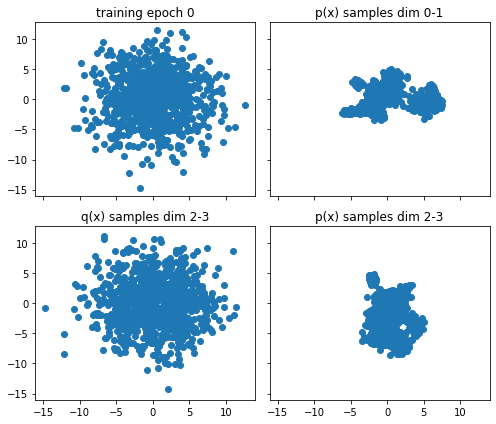

loss: -2.542226150231557, mean log p_x -25.389209461527194:  10%|█         | 2000/20000 [13:00<1:50:04,  2.73it/s] 

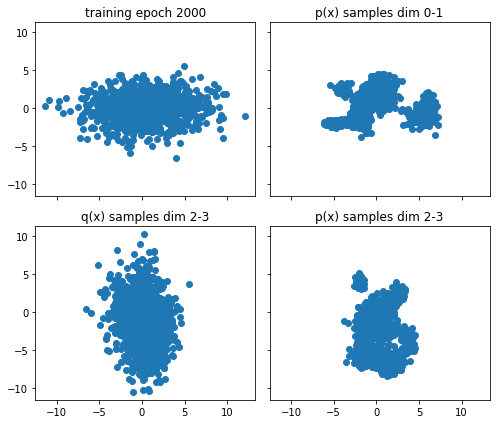

loss: -2.548725061529229, mean log p_x -22.349866206351514:  20%|██        | 4000/20000 [25:43<1:38:39,  2.70it/s] 

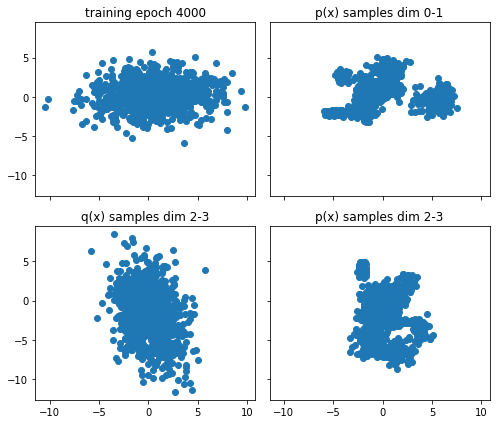

loss: -2.762821763191833, mean log p_x -19.451860902133657:  30%|███       | 6000/20000 [41:27<1:50:11,  2.12it/s] 

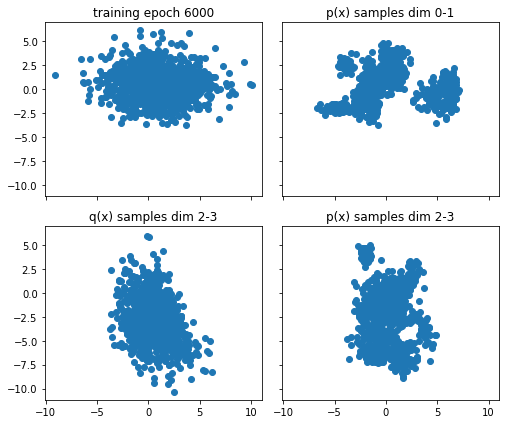

loss: -2.6021422557771974, mean log p_x -18.508343350757738:  40%|████      | 8000/20000 [55:24<1:14:40,  2.68it/s]

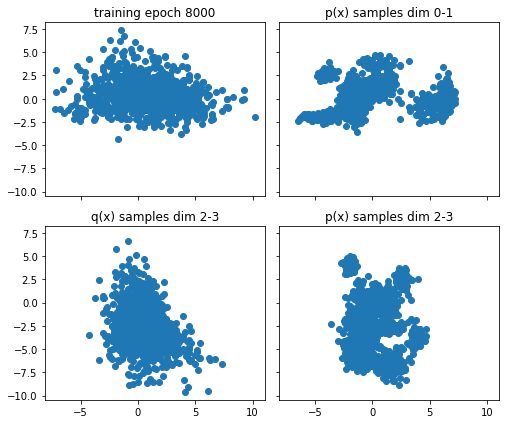

loss: -2.6331761075763334, mean log p_x -18.565558662852556:  50%|█████     | 10000/20000 [1:07:50<1:04:17,  2.59it/s]

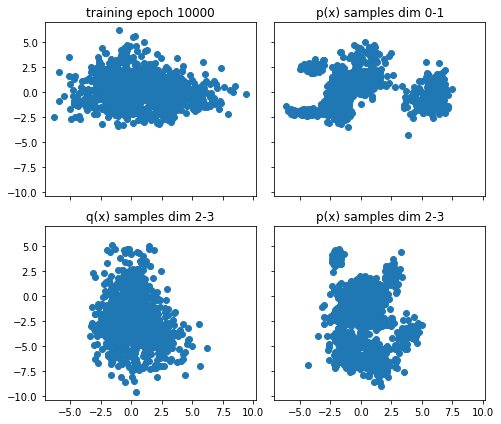

loss: -2.397761047437312, mean log p_x -18.17380014043529:  60%|██████    | 12000/20000 [1:18:38<36:12,  3.68it/s]    

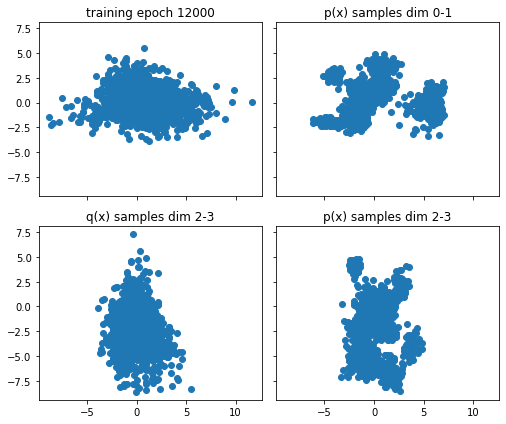

loss: -2.686986893929493, mean log p_x -18.00615308735166:  70%|███████   | 14000/20000 [1:28:14<28:05,  3.56it/s]   

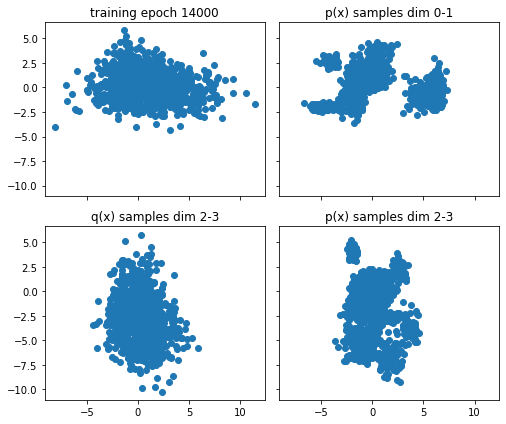

loss: -2.58701914541937, mean log p_x -17.94573385314918:  80%|████████  | 16000/20000 [1:37:03<17:16,  3.86it/s]   

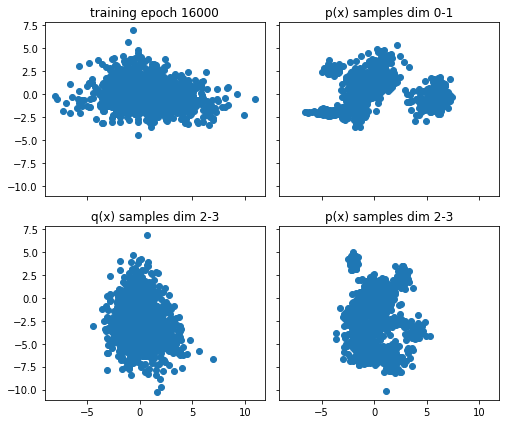

loss: -2.0189090639079987, mean log p_x -17.511638026389825:  90%|█████████ | 18000/20000 [1:45:59<08:40,  3.84it/s]

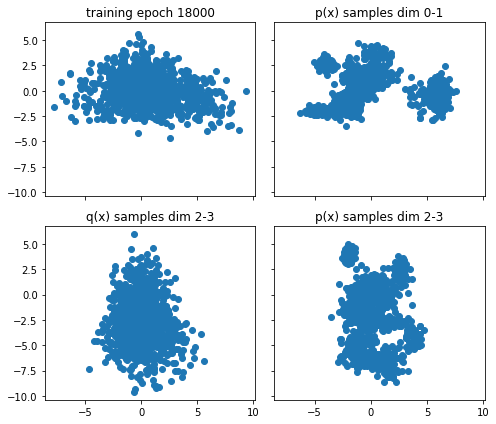

loss: -2.3677566511140173, mean log p_x -17.266761370257413: 100%|██████████| 20000/20000 [1:54:46<00:00,  2.90it/s]


In [12]:
history = tester.train(epochs, batch_size=batch_size, intermediate_plots=True, plotting_func=plotter) #clip_grad_norm=True, max_grad_norm=1)

In [13]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

if train_prior:
    print(f"estimate after prior training is {expectation_prior_trained} \n"
        f"effective sample size trained prior is {info_prior['effective_sample_size'] / n_samples_estimation}\n")

estimate before training is 48.768740795819085 
estimate after training is 55.62891177254937 
effective sample size before is 0.006385696756176886
effective sample size after train is 0.05286944580876792
variance in weights is 1.791453431811592e-11


In [14]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

if train_prior:
    print(f"estimate after prior training is {expectation_prior_trained} \n"
        f"effective sample size trained prior is {info_prior['effective_sample_size'] / n_samples_estimation}\n")

estimate before training is 48.768740795819085 
estimate after training is 55.62891177254937 
effective sample size before is 0.006385696756176886
effective sample size after train is 0.05286944580876792
variance in weights is 1.791453431811592e-11


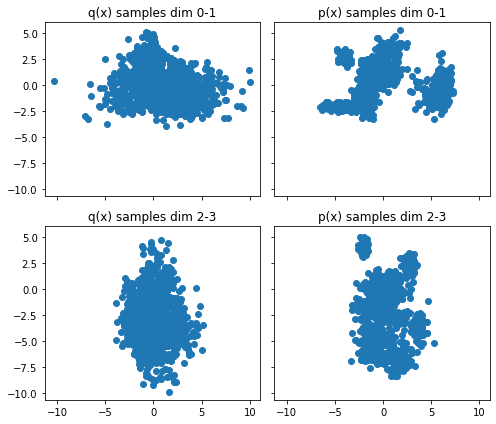

In [15]:
samples_fig_after = plot_samples(tester)

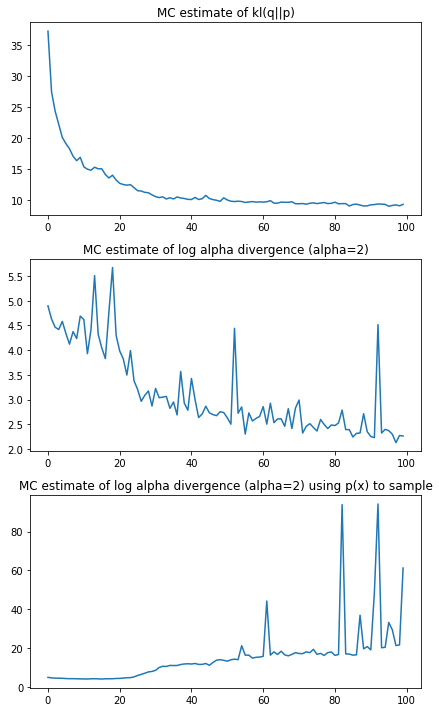

In [16]:
plot_divergences(history)

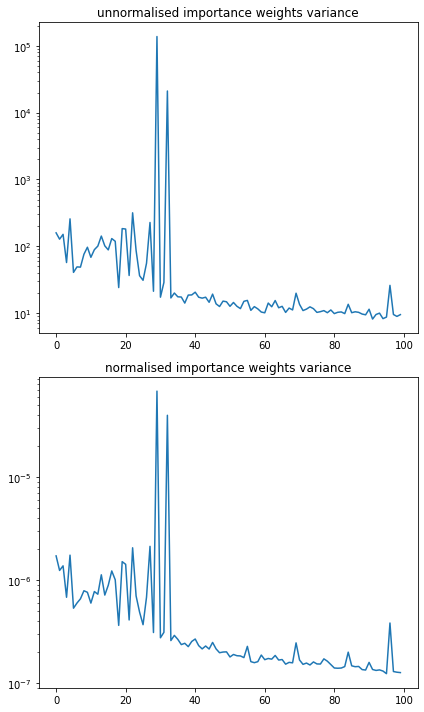

In [17]:
plot_sampling_info(history)

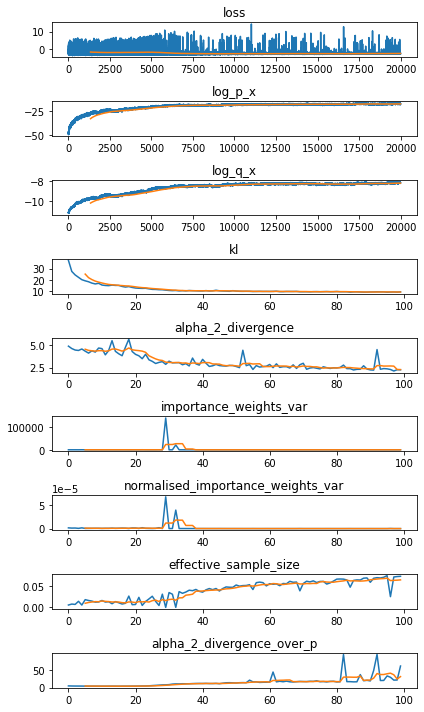

In [18]:
plot_history(history)

# KL

In [19]:
annealing=True

In [20]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=scaling_factor, flow_type="RealNVP")
tester_kl = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl", lr=lr, 
                                  weight_decay=1e-6, annealing=annealing)
expectation_before_kl, info_before_kl = tester.estimate_expectation(n_samples_estimation, expectation_function)

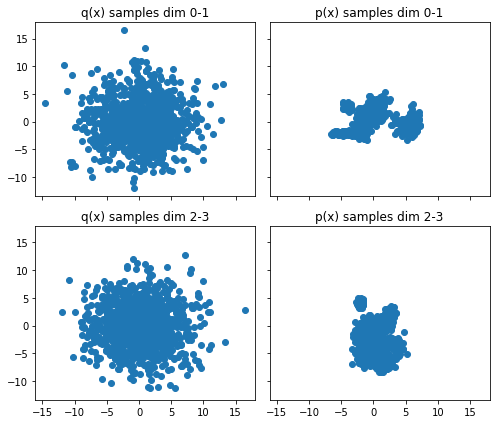

In [21]:
plot_samples(tester_kl)

In [ ]:
history_kl = tester_kl.train(epochs, batch_size=batch_size, intermediate_plots=True)

loss: -3.273292650422645, mean log p_x -10.717860832881634:  21%|██        | 4201/20000 [14:29<1:15:46,  3.48it/s] 

Couldn't calculate alpha divergence over p


loss: -3.055400669486869, mean log p_x -10.375499540931038:  22%|██▏       | 4401/20000 [15:11<1:15:37,  3.44it/s]

Couldn't calculate alpha divergence over p


loss: -2.813716598355414, mean log p_x -10.484301409281745:  23%|██▎       | 4601/20000 [15:53<1:15:20,  3.41it/s] 

Couldn't calculate alpha divergence over p


loss: -2.6340442470598275, mean log p_x -10.152815159493798:  24%|██▍       | 4801/20000 [16:35<1:14:08,  3.42it/s]

Couldn't calculate alpha divergence over p


loss: -2.4127581956755804, mean log p_x -10.091727328009197:  25%|██▌       | 5001/20000 [17:16<1:13:27,  3.40it/s]

Couldn't calculate alpha divergence over p


loss: -2.257903295434737, mean log p_x -9.887911864884725:  26%|██▌       | 5201/20000 [17:58<1:11:46,  3.44it/s]  

Couldn't calculate alpha divergence over p


loss: -2.169967700664549, mean log p_x -9.657347310798768:  27%|██▋       | 5401/20000 [18:41<1:17:55,  3.12it/s]

Couldn't calculate alpha divergence over p


loss: -1.923483574005071, mean log p_x -9.599181775315026:  28%|██▊       | 5601/20000 [19:23<1:09:40,  3.44it/s]

Couldn't calculate alpha divergence over p


loss: -1.8341259177248816, mean log p_x -9.266777594567742:  29%|██▉       | 5801/20000 [20:04<1:16:53,  3.08it/s]

Couldn't calculate alpha divergence over p


loss: -1.7110040949049663, mean log p_x -9.065839265607126:  30%|███       | 6000/20000 [20:46<46:36,  5.01it/s]  

Couldn't calculate alpha divergence over p


loss: -1.5779920225315969, mean log p_x -8.981973526766621:  31%|███       | 6142/20000 [21:15<45:24,  5.09it/s]  

In [ ]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

In [ ]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester_kl)

In [ ]:
plot_divergences(history_kl)

In [ ]:
plot_sampling_info(history_kl)

In [ ]:
hist_plot = plot_history(history_kl)